In [5]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from parser import parser, parse_data
from config import DATA_DOWNLOAD_URL
import geopandas
from shapely import Polygon
from shapely.prepared import prep
import os
from collections import defaultdict
import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#load 3 of the different files that each represent one tile form MODIS data (arbitrary) juste for having coords
h17v04Grid = parser(f"{DATA_DOWNLOAD_URL}/raw/2025-01-16/MOD13Q1.A2025001.h17v04.061.2025022084544.hdf", convertCoords=True)
h18v04Grid = parser(f"{DATA_DOWNLOAD_URL}/raw/2025-01-16/MOD13Q1.A2025001.h18v04.061.2025022083416.hdf", convertCoords=True)
h18v03Grid = parser(f"{DATA_DOWNLOAD_URL}/raw/2025-01-16/MOD13Q1.A2025001.h18v03.061.2025022080925.hdf", convertCoords=True)

In [13]:
#make a polygon of the tile
coord_list = list(map(float, h17v04Grid["meta"][0]["polygons"][0][0].split()))
coordinates = [(coord_list[i+1], coord_list[i]) for i in range(0, len(coord_list), 2)]
h17v04polygon = Polygon(coordinates)

#make a dict with points and indices to retreive valid data (dict search quicker than for loops)
h17v04lon = h17v04Grid["lons"].flatten()
h17v04lats = h17v04Grid["lats"].flatten()
h17v04points = geopandas.points_from_xy(x=h17v04lon, y=h17v04lats)
h17v04point_index_map = {point: idx for idx, point in enumerate(h17v04points)} 

In [3]:
#same thing for other tile
coord_list = list(map(float, h18v04Grid["meta"][0]["polygons"][0][0].split()))
coordinates = [(coord_list[i+1], coord_list[i]) for i in range(0, len(coord_list), 2)]
h18v04polygon = Polygon(coordinates)
h18v04lon = h18v04Grid["lons"].flatten()
h18v04lats = h18v04Grid["lats"].flatten()
h18v04points = geopandas.points_from_xy(x=h18v04lon, y=h18v04lats)
h18v04point_index_map = {point: idx for idx, point in enumerate(h18v04points)}

In [51]:
#same thing for other tile
coord_list = list(map(float, h18v03Grid["meta"][0]["polygons"][0][0].split()))  # Convert to list of floats
coordinates = [(coord_list[i+1], coord_list[i]) for i in range(0, len(coord_list), 2)]
h18v03polygon = Polygon(coordinates)
h18v03lon = h18v03Grid["lons"].flatten()
h18v03lats = h18v03Grid["lats"].flatten()
h18v03points = geopandas.points_from_xy(x=h18v03lon, y=h18v03lats)
h18v03point_index_map = {point: idx for idx, point in enumerate(h18v03points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

In [16]:
#read polygons values from dict for france departments
geo = geopandas.read_file("data/geojsonfrance_corse_20.json") #get polygon values for each french dep
geo["code"] = geo["code"].astype(int)
geo = geo.sort_values(by="code").reset_index(drop=True)

In [72]:
#Here, we loop throught every france departement. 
#We open previously computed (gridded with step) points for that department
#To optimize, we first check if at least one of department polygon is inside each tile, if not, we pass which gains time
#If the dep is in the tile, we open previously computed monthly average data
#We compute the indices of points inside the department (HERE we have a loss of data because of very small floating point variation when converting meters to lat and lon
#    the loss is small (1-5%)
# then we mask the wanted data with indices
#We mean every data in the department to get the monthly, department average
#we store it in a json file in format (Name, Code, Date, EVI)

for _,dep in geo.iterrows(): 
    with open(f"data/coords/{dep["code"]}-{dep["nom"]}.json") as f:
        coords_dep = json.load(f)
    points_dep = geopandas.points_from_xy(x=coords_dep["valid_lon"], y=coords_dep["valid_lat"])
    fullData = []
    for directory in os.listdir(f"{DATA_DOWNLOAD_URL}/monthly/"):
        data_list = []
        
        if dep["geometry"].intersects(h17v04polygon):         
            data = np.load(f"{DATA_DOWNLOAD_URL}/monthly/{directory}/h17v04.npy").flatten()
            
            valid_indices = [h17v04point_index_map[point] for point in points_dep if point in h17v04point_index_map]        

            valid_data = [data[i] for i in valid_indices] #get data from indices list
            
            data_list.extend(valid_data)

        if dep["geometry"].intersects(h18v03polygon):          
            data = np.load(f"{DATA_DOWNLOAD_URL}/monthly/{directory}/h18v03.npy").flatten()
            
            valid_indices = [h18v03point_index_map[point] for point in points_dep if point in h18v03point_index_map] #get indexes for valid_point found
            valid_data = [data[i] for i in valid_indices] #get data from indices list

            data_list.extend(valid_data)

        if dep["geometry"].intersects(h18v04polygon):
            data = np.load(f"{DATA_DOWNLOAD_URL}/monthly/{directory}/h18v04.npy").flatten()
            
            valid_indices = [h18v04point_index_map[point] for point in points_dep if point in h18v04point_index_map]   
            valid_data = [data[i] for i in valid_indices] #get data from indices list

            data_list.extend(valid_data)
            
        mean_data = np.nanmean(data_list)  
        fullData.append({"name": dep["nom"], "code": dep["code"], "date": directory, "mean_data": mean_data})
    with open(f"{DATA_DOWNLOAD_URL}/monthlyDepMean/{dep["code"]}-{dep["nom"]}.json", "w") as outfile:
        outfile.write(json.dumps(fullData))

    

KeyboardInterrupt: 

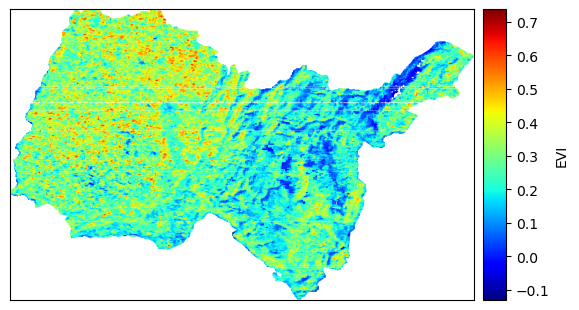

In [31]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(res["valid_lat"]),  urcrnrlat=np.max(res["valid_lat"]),
            llcrnrlon=np.min(res["valid_lon"]), urcrnrlon=np.max(res["valid_lon"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(res["valid_lon"], res["valid_lat"], c=res["valid_data"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

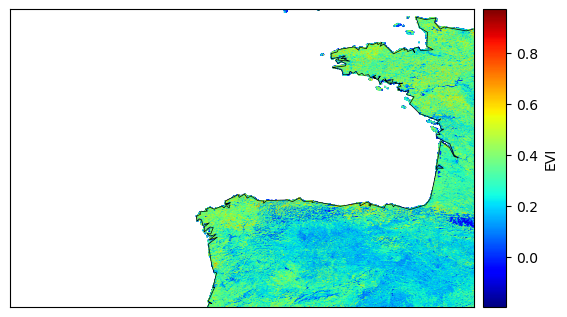

In [49]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data1["lats"]),  urcrnrlat=np.max(data1["lats"]),
            llcrnrlon=np.min(data1["lons"]), urcrnrlon=np.max(data1["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data1["lons"], data1["lats"], c=data1["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

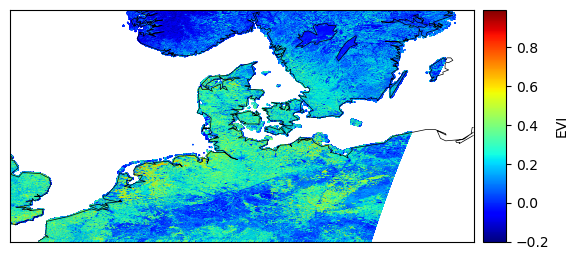

In [50]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data2["lats"]),  urcrnrlat=np.max(data2["lats"]),
            llcrnrlon=np.min(data2["lons"]), urcrnrlon=np.max(data2["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data2["lons"], data2["lats"], c=data2["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

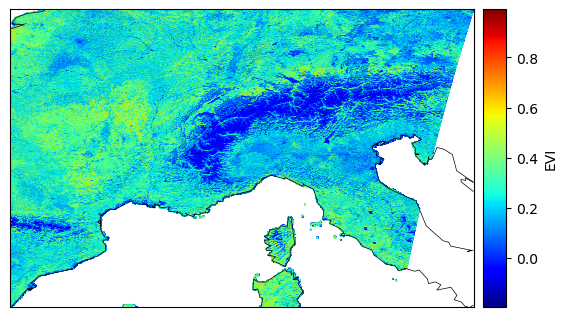

In [51]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data3["lats"]),  urcrnrlat=np.max(data3["lats"]),
            llcrnrlon=np.min(data3["lons"]), urcrnrlon=np.max(data3["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data3["lons"], data3["lats"], c=data3["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()